Finetuning tuto

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ae_auyun
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ae_auyun
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263899 sha256=7c9cae012d67a7075cfe265b962da1c2888789e319bff554bfb816e2506a7ebd
  Stored in directory: /tmp/pip-ephem-wheel-cache-3guhwola/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [2]:
from os import path
import urllib.request
import zipfile

if path.isdir('PennFudanPed'):
  print('dataset already downloaded')
else:
  # download the Penn-Fudan dataset
  url = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
  urllib.request.urlretrieve(url, filename = 'PennFudanPed.zip')
  # extract it in the current folder
  with zipfile.ZipFile('PennFudanPed.zip', 'r') as zip_ref:
    zip_ref.extractall()
  print('dataset downloaded and extracted')

dataset downloaded and extracted


Text(0.5, 1.0, 'Mask')

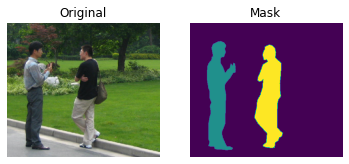

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_path = 'PennFudanPed/PNGImages/FudanPed00096.png'
original = Image.open('PennFudanPed/PNGImages/FudanPed00074.png')

mask = Image.open('PennFudanPed/PedMasks/FudanPed00074_mask.png')
mask.putpalette([
    0,0,0,
    255,0,0,
    255,255,0,
    255,153,0,
])
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(np.asarray(original))
plt.axis('off')
plt.title('Original')
fig.add_subplot(1,2,2)
plt.imshow(np.asarray(mask))
plt.axis('off')
plt.title('Mask')

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self,idx):
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        
        img = Image.open(img_path).convert('RGB')

        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        #remove first id (background)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1] * (boxes[:, 2] - boxes[:, 0]))
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
          img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F3316B80B50>,
 {'area': tensor([-25272., -19065.]),
  'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

#prepare for custom dataset
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    return model

In [7]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 27557, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 27557 (delta 79), reused 21 (delta 3), pack-reused 27450
Receiving objects: 100% (27557/27557), 36.06 MiB | 29.05 MiB/s, done.
Resolving deltas: 100% (20683/20683), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train = True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle = True,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn) 
data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle = False,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2 #background and person
model = get_instance_segmentation_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9,
                            weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


cuda


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [11]:
num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:18  lr: 0.000090  loss: 2.7294 (2.7294)  loss_classifier: 0.7856 (0.7856)  loss_box_reg: 0.2727 (0.2727)  loss_mask: 1.6452 (1.6452)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 1.3162  data: 0.2235  max mem: 2582
Epoch: [0]  [10/60]  eta: 0:00:30  lr: 0.000936  loss: 1.7505 (1.8005)  loss_classifier: 0.5679 (0.5092)  loss_box_reg: 0.3080 (0.3497)  loss_mask: 0.7230 (0.9124)  loss_objectness: 0.0156 (0.0229)  loss_rpn_box_reg: 0.0057 (0.0062)  time: 0.6142  data: 0.0289  max mem: 2911
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 0.8243 (1.2566)  loss_classifier: 0.1955 (0.3432)  loss_box_reg: 0.2794 (0.3001)  loss_mask: 0.3028 (0.5882)  loss_objectness: 0.0117 (0.0195)  loss_rpn_box_reg: 0.0038 (0.0056)  time: 0.5245  data: 0.0096  max mem: 2911
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.5682 (1.0413)  loss_classifier: 0.1053 (0.2605)  loss_box_reg: 0.2664 (0.2997)  loss_mask: 0.1803 (0.4614)  loss_ob

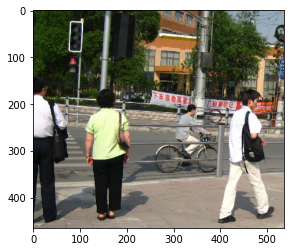

In [48]:
img, _ = dataset_test[20]
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

plt.imshow(np.asarray(img.mul(255).permute(1, 2, 0).byte().numpy()))

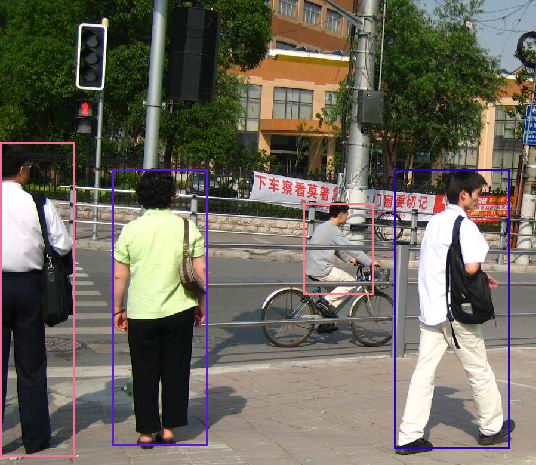

In [56]:
from PIL import ImageDraw
import random

og = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
vertex = prediction[0]['boxes'].cpu().detach().numpy()

draw = ImageDraw.Draw(og)
for v in vertex:
  r = int(random.random()*255)
  b = int(random.random()*255)
  g = int(random.random()*255) 
  color = (r,g,b)
  draw.rectangle(v, fill=None, outline=color, width=2)
og.save('out_file.png')
Image.open('out_file.png')

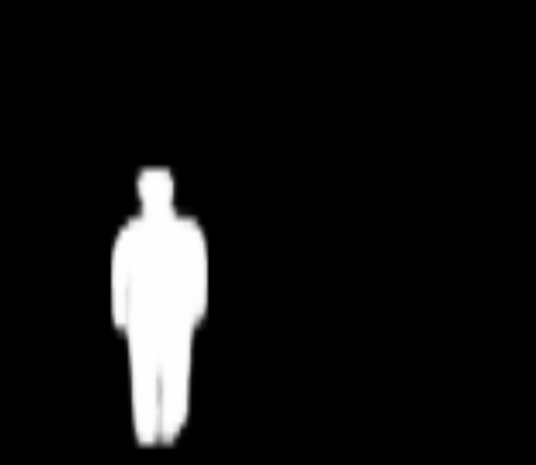

In [57]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [58]:
#class for different mask generation
class mask_mod():
  def __init__(self, masks, filter):
    self.masks = masks
    self.filter = filter

  #this function generates a mask for all predictions
  def generate_full_mask(self):
    full_mask = self.masks[0,0]
    for i in range(1,len(self.masks)):
      full_mask = full_mask + self.masks[i,0]
    full_mask[full_mask>=self.filter] = 1
    Image.fromarray(full_mask.mul(255).byte().cpu().numpy())

    return full_mask

  def generate_binary_mask(self):
    full_mask = self.masks[0,0]
    for i in range(1,len(self.masks)):
      full_mask = full_mask + self.masks[i,0]
    full_mask[full_mask>=self.filter] = 1
    full_mask[full_mask<self.filter] = 0
    Image.fromarray(full_mask.mul(255).byte().cpu().numpy())
    return full_mask

#array of mask prediction from GPU to PIL.Image.fromarray readable
def array_to_pillow(array):
  result = array.mul(255).byte().cpu().numpy()
  return result

Testing full masks!

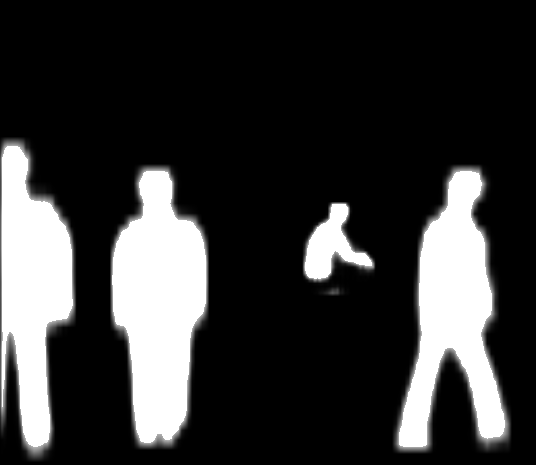

In [59]:
filtering_param = 0.7
maskmodder = mask_mod(prediction[0]['masks'],filtering_param)
full = maskmodder.generate_full_mask()
Image.fromarray(array_to_pillow(full))

Testing Binary masks!

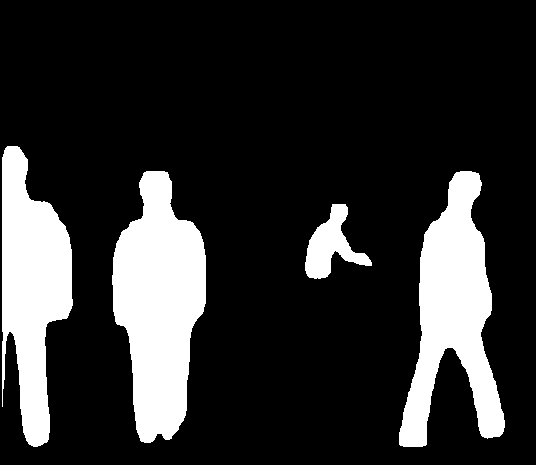

In [60]:
binary = maskmodder.generate_binary_mask()
Image.fromarray(array_to_pillow(binary))